Download packages

In [92]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
from sklego.meta import OrdinalClassifier
from sklearn.inspection import DecisionBoundaryDisplay
import scipy
from sklearn.metrics import balanced_accuracy_score

In [93]:
random.seed(8)

Create new feature names to take the mean and std across epochs pr person

Concatenate data

In [94]:
path ='CSV_features_NEW/'
folder = os.fsencode(path)
renamed_markers_list = ['No.', 'Event', 'Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
m_list = ['Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
mean_list = [i + '_mean' for i in m_list]
std_list = [i + '_std' for i in m_list]


patient_numbers = []
r_data = []
m_data = []
f_data = []

all_data = []


for file in os.listdir(folder):
    filename = os.fsdecode(file)
    patient_numbers.append(filename[0:3])
    fname = path + filename
    data = pd.read_csv(fname)
    data.columns = renamed_markers_list
    all_data.append(data)



In [95]:
len(all_data)

74

Ignore irrelevant warnings

In [96]:
warnings.filterwarnings(action='ignore', category=FutureWarning)

Forward feature selection for each person to find relevant features

In [97]:
#using mlxtend
t = pd.CategoricalDtype(categories = ['R', 'M', 'F'], ordered = True)

scores = []
chosen_features_list = []
subsets_list = []
components_list = []
explained_var = []
improving = True
prev_score = 0
for i in range(len(all_data)):
    best_comp = []
    train_y = pd.Series(all_data[i]['Event'],dtype=t).cat.codes
    train_X = all_data[i][m_list]
    n_components = 0.95
    pca = sklearn.decomposition.PCA(n_components=n_components)
    train_X = sklearn.preprocessing.StandardScaler().fit(train_X).transform(train_X)
    train_X = pca.fit_transform(train_X)
    components_list.append(pca.components_)
    explained_var.append(pca.explained_variance_ratio_)
    train_X = pd.DataFrame(train_X)
    ord_clf = OrdinalClassifier(estimator=LogisticRegression())
    for j in range(1,train_X.shape[1]):
        #print(j)
        sfs = SFS(ord_clf, k_features=j, forward=True, floating=False,verbose=0, cv=3, scoring='balanced_accuracy') #cv = number of splits in crossval, automaticly it has stratifies kfold
        sfs.fit(train_X, train_y)
        new_score = sfs.k_score_
        #print(new_score-prev_score)
        if new_score - prev_score <= 0.01:
            #print(j-1, prev_score)
            prev_score = 0
            break
        else:
            features = sfs.k_feature_names_
            prev_score = new_score
    chosen_features_list.append(features)

#print(chosen_features_list)
   

In [119]:
print([(chosen_features_list[i], patient_numbers[i]) for i in B])

[((0, 1, 2), 'p16'), ((0, 4), 'p31'), ((6, 7), 'p3_'), ((4, 5), 'p45'), ((0, 1, 3), 'p49'), ((1, 4, 5), 'p4_'), ((1, 5, 7), 'p54'), ((4, 7), 'p5_'), ((5, 7), 'p61'), ((2, 4, 7), 'p62'), ((0, 8), 'p63'), ((0, 2, 3, 4), 'p66'), ((1,), 'p68'), ((4,), 'p75'), ((0,), 'p76'), ((0, 4), 'p78')]


In [98]:
import sklearn.model_selection


outer_loops = 3
inner_loops = 3
cv_v2_scores = np.empty((len(all_data), outer_loops, inner_loops))
predictions = np.empty((len(all_data), outer_loops,23))
t = pd.CategoricalDtype(categories = ['R', 'M', 'F'], ordered = True)

train_id = []
test_id = []
#print(all_data[i]['Event'])
for i in range(len(all_data)):
    best_comp = [*chosen_features_list[i]]
    train_y = pd.Series(all_data[i]['Event'],dtype=t).cat.codes
    train_X = all_data[i][m_list]
    n_components = 0.95
    pca = sklearn.decomposition.PCA(n_components=n_components)
    train_X = sklearn.preprocessing.StandardScaler().fit(train_X).transform(train_X)
    #train_X = pca.fit_transform(train_X)
    train_X = pd.DataFrame(train_X)

    ord_clf = OrdinalClassifier(estimator=LogisticRegression())
    for j in range(outer_loops):
        skf = StratifiedKFold(n_splits=inner_loops, random_state=j, shuffle=True)
        scores = sklearn.model_selection.cross_val_score(ord_clf, np.array(train_X.iloc[:,best_comp]), np.array(train_y), cv = skf, scoring='balanced_accuracy')
        cv_v2_scores[i, j] = scores
        prediction = sklearn.model_selection.cross_val_predict(ord_clf, np.array(train_X.iloc[:,best_comp]), np.array(train_y), cv = skf, method='predict')
        predictions[i,j,:len(prediction)] = prediction

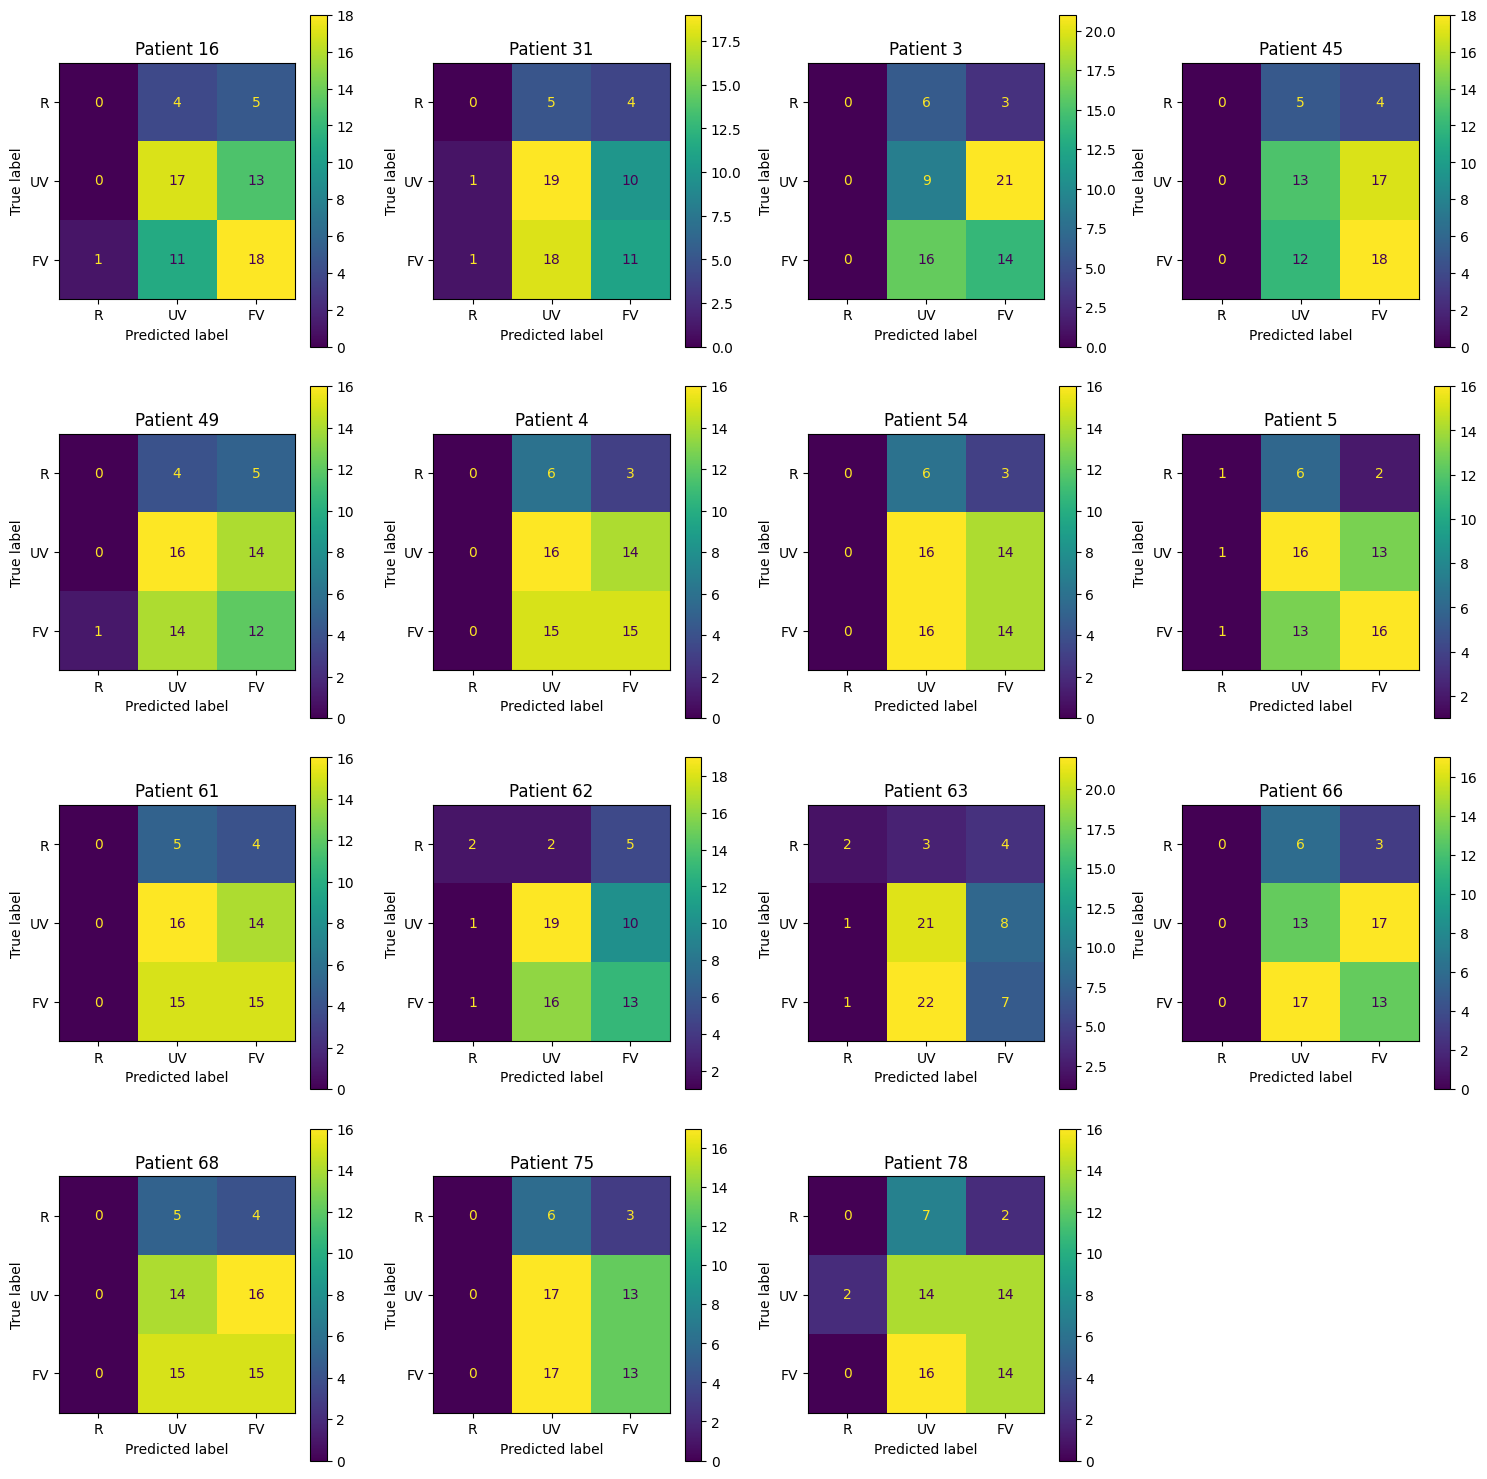

In [90]:
"""import sklearn.metrics

fig, axes = plt.subplots(4,4, figsize=(15,15))
for i, ax in zip(B, axes.flatten()):
    t = pd.CategoricalDtype(categories = ['R', 'M', 'F'], ordered = True)
    true_labels = np.repeat(pd.Series(all_data[i]['Event'],dtype=t).cat.codes,3)
    predicted_labels = predictions[i,:,:len(all_data[i]['Event'])].flatten()
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true=true_labels,y_pred=predicted_labels,ax=ax, display_labels=['R', 'UV', 'FV'])
    title = patient_numbers[i].strip('_')[1:]
    title = 'Patient ' + title
    ax.set_title(title)
plt.delaxes(axes[3,3])
plt.tight_layout()
plt.show()"""

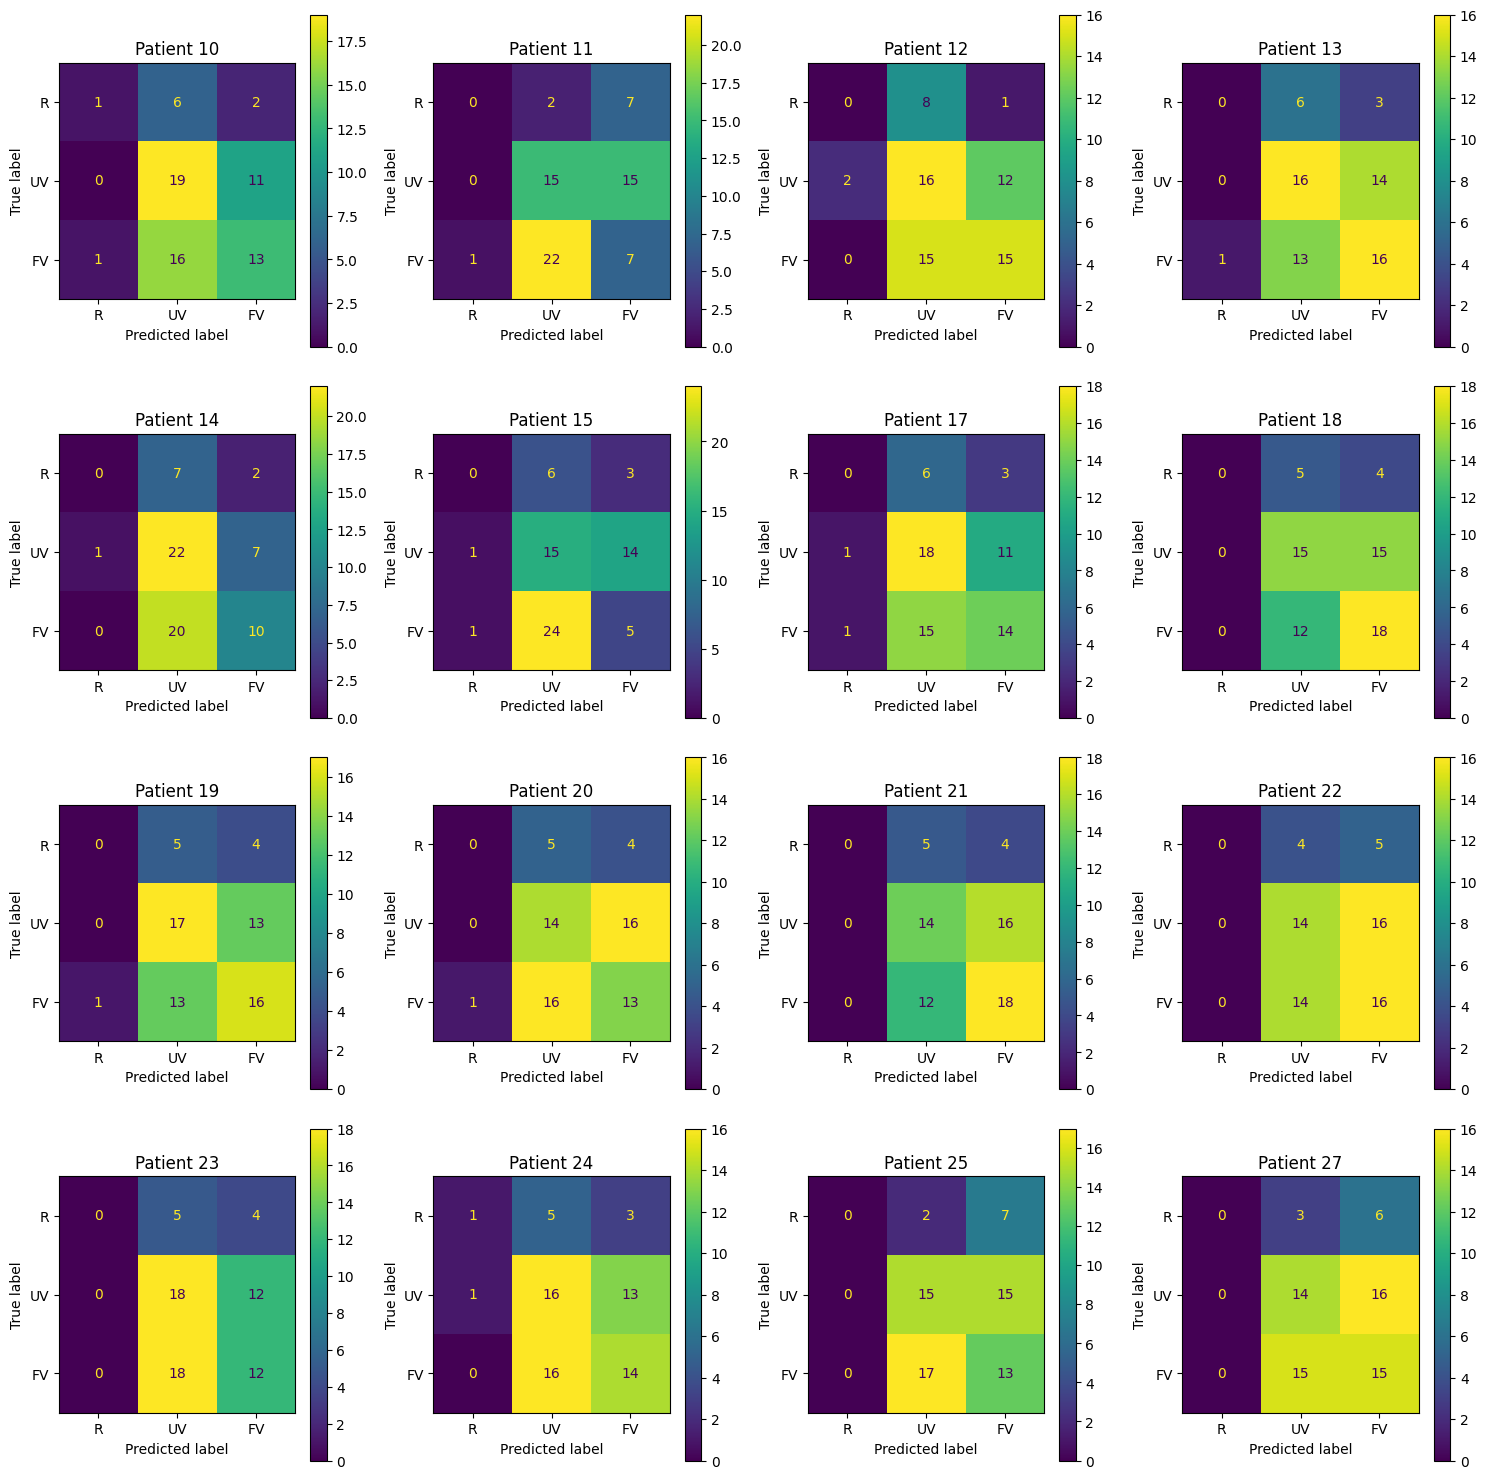

In [89]:
"""D = [i for i in range(17) if i not in B]
fig, axes = plt.subplots(4,4, figsize=(15,15))
for i, ax in zip(D, axes.flatten()):
    t = pd.CategoricalDtype(categories = ['R', 'M', 'F'], ordered = True)
    true_labels = np.repeat(pd.Series(all_data[i]['Event'],dtype=t).cat.codes,3)
    predicted_labels = predictions[i,:,:len(all_data[i]['Event'])].flatten()
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true=true_labels,y_pred=predicted_labels,ax=ax, display_labels=['R', 'UV', 'FV'])
    title = patient_numbers[i].strip('_')[1:]
    title = 'Patient ' + title
    ax.set_title(title)
#plt.delaxes(axes[3,3])
plt.tight_layout()
plt.show()"""

In [99]:
#adjusted from sklearn (https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    s = 200
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        scatter = ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
            s=s,
            facecolor='None',
        )

    # Plot the data classes and groups at the end
    scatter2 = ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data, s=s, facecolor='none',
    )

    #ax.scatter(
    #    range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    #)

    # Formatting
    yticklabels = ['Fold ' + str(i) for i in range(1,3+1)] + ["Event"]
    ax.set(
        yticks=np.arange(n_splits+1) + 0.5,
        xticks=np.arange(0,23),
        xticklabels=list(range(1,24)),
        yticklabels=yticklabels,
        xlabel="Epoch",
        ylim=[n_splits + 1.2, -0.2],
        xlim=[-0.5, len(X)-0.5],
    )
    handles, labels = scatter.legend_elements()
    handles2, labels = scatter2.legend_elements()
    #legend1 = ax.legend(handles=handles, labels=['Train', 'Test'],
    #                loc="lower left", title="Classes")    #ax.axvline(2.5)
    #ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax, handles, handles2

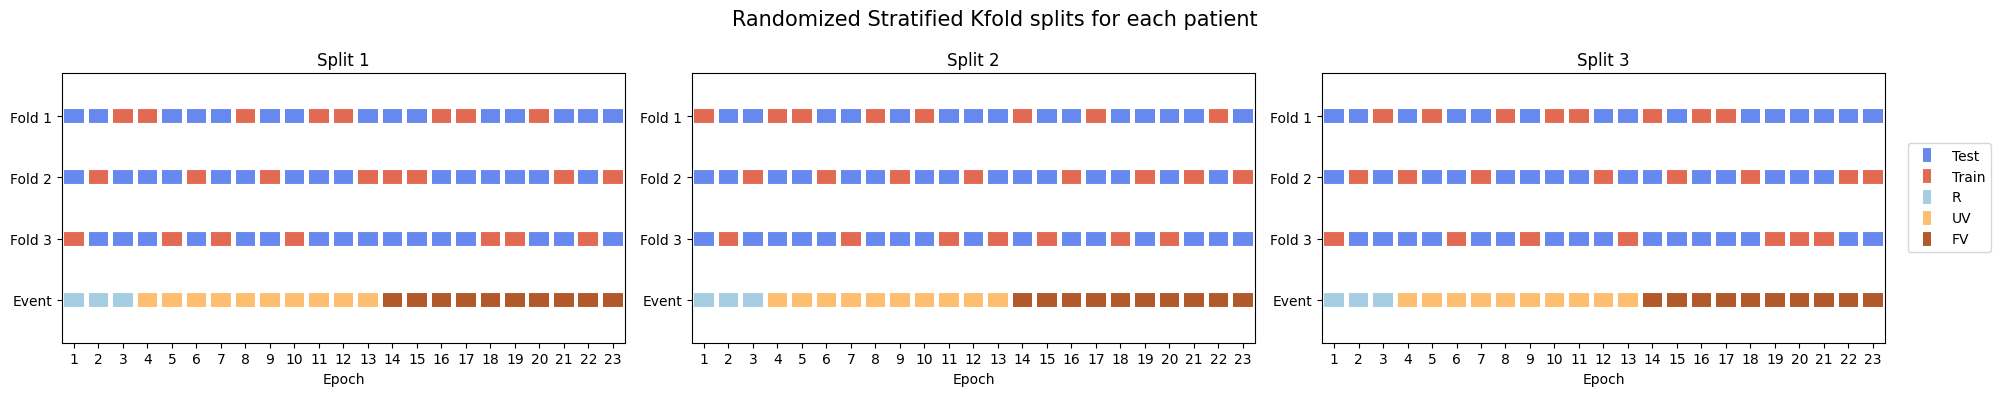

In [100]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

cv_list = [StratifiedKFold(3, shuffle=True, random_state=i) for i in range(3)]
fig, axes = plt.subplots(ncols=4, figsize=(20,4), width_ratios=[1,1,1,0.05]) 
for i in range(3):
    ax, handles, handles2 = plot_cv_indices(cv_list[i], train_X, train_y, train_y, axes[i], 3)
    axes[i].set_title('Split ' + str(i+1))
axes[3].axis('off')
fig.legend(handles+handles2, ['Test','Train', 'R', 'UV', 'FV'], loc='right')
plt.suptitle('Randomized Stratified Kfold splits for each patient', fontsize=15)
plt.tight_layout()

In [101]:
# Inspecting responders from t-test
import scipy.stats


B = set()
zu = []
rh_liste = []
o2_liste = []

for count, i in enumerate(cv_v2_scores):
    j = 5
    k = 3
    df = j-1
    rho = 1/k

    rand_err = 2/3
    rj = np.mean((1-i)-rand_err, axis=0)
    rh = np.mean(rj)
    rh_liste.append(rh)

    s = 0

    for e in rj:
        s += (e-rh)**2
    
    s2 = 1/(j-1) * s
    o2 = (1/j + rho/(1-rho)) * s2
    o2_liste.append(o2)
    
    zu.append(scipy.stats.t.ppf(1-0.05, df, rh, np.sqrt(o2))) # upper bound confidence interval
    t = rh/(np.sqrt(o2))
    p = scipy.stats.t.cdf(t, df)
    if p <= 0.05:
        #print(count, patient_numbers[count], p)
        B.add(count)

#print('Correlated t-test responders: ', sorted(B), len(B))
B = sorted(B)


c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\KSOE0397\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\Users\KSOE0397\AppData\Local\Temp\ipykernel_13920\1138575720.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  t = rh/(np.sqrt(o2))


In [102]:
responders = []
non_responders = []

for i in range(len(all_data)):
    if i in B:
        responders.append([np.mean(1-cv_v2_scores[i,:]), np.std(np.mean(1-cv_v2_scores[i,:], axis=0))/np.sqrt(3), zu[i], rh_liste[i], o2_liste[i]])
    else:
        non_responders.append([np.mean(1-cv_v2_scores[i,:]), np.std(np.mean(1-cv_v2_scores[i,:], axis=0))/np.sqrt(3), zu[i], rh_liste[i], o2_liste[i]])

# Group sizes
print('Number of responders: ', len(responders))
print('Number of non-responders: ', len(non_responders))

Number of responders:  16
Number of non-responders:  58


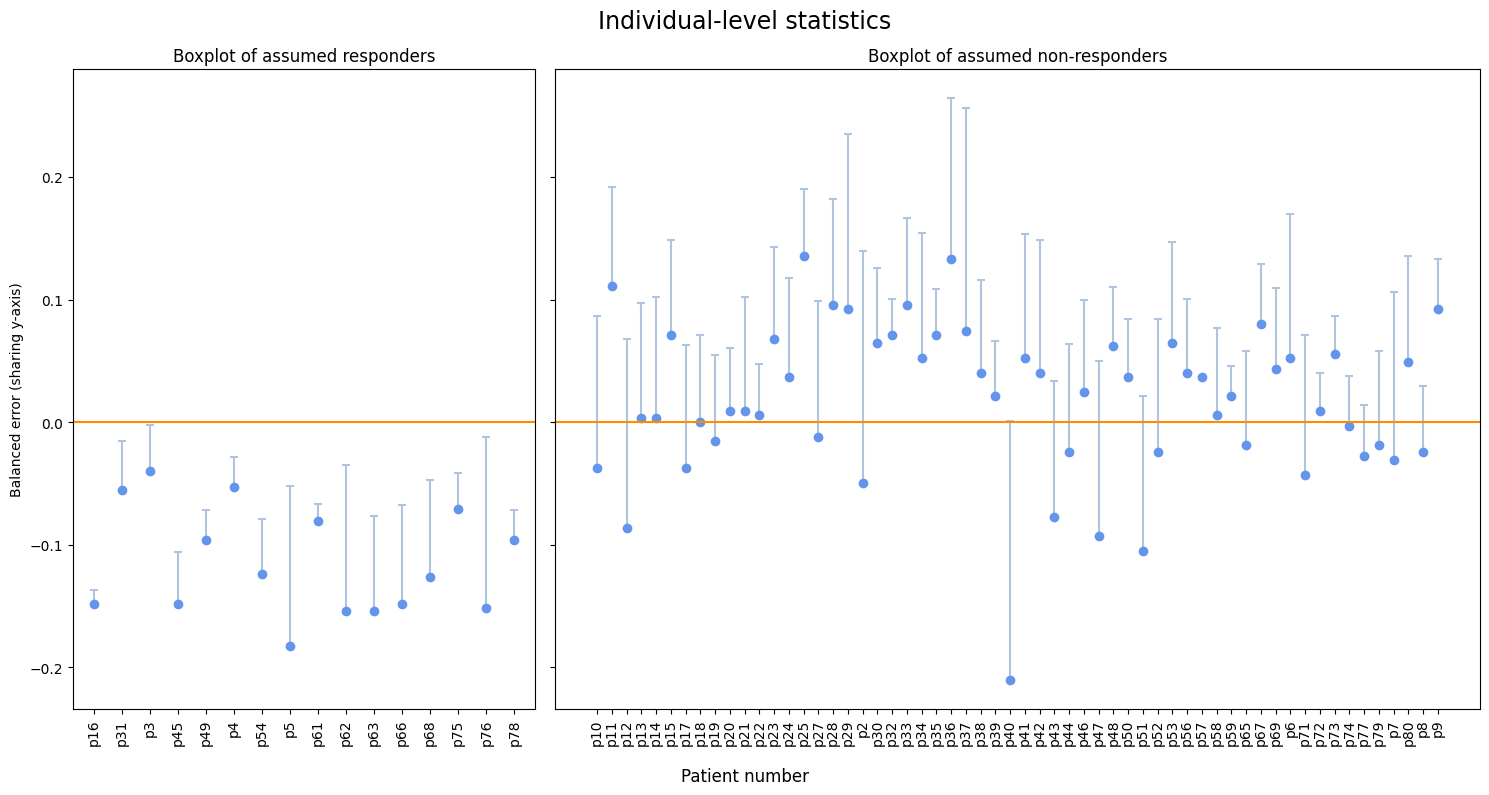

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,8), gridspec_kw={'width_ratios':[1,2]})

means_r = []
std_r = []
zu_r = []
rh_r = []
o2_r = []

means_nr = []
std_nr = []
zu_nr = []
rh_nr = []
o2_nr = []

for i in responders:
    means_r.append(i[0])
    std_r.append(i[1])
    zu_r.append(i[2])
    rh_r.append(i[3])
    o2_r.append(np.sqrt(i[4])/np.sqrt(3))

for j in non_responders:
    means_nr.append(j[0])
    std_nr.append(j[1])
    zu_nr.append(j[2])
    rh_nr.append(j[3])
    o2_nr.append(np.sqrt(j[4])/np.sqrt(3))

#ax1.errorbar(x=range(len(responders)), y=rh_r, yerr=o2_r, fmt='o', ecolor='lightsteelblue', elinewidth=2, capsize=0, color='cornflowerblue')
#ax2.errorbar(x=range(len(non_responders)), y=rh_nr, yerr=o2_nr, fmt='o', ecolor='lightsteelblue', elinewidth=2, capsize=0, color='cornflowerblue')



ax1.vlines(x=range(len(responders)), ymin=rh_r, ymax=zu_r, colors='lightsteelblue', zorder=0)
ax2.vlines(x=range(len(non_responders)), ymin=rh_nr, ymax=zu_nr, colors='lightsteelblue', zorder=0)

ax1.scatter(x=range(len(responders)), y=rh_r, c='cornflowerblue', zorder=1)
ax2.scatter(x=range(len(non_responders)), y=rh_nr, c='cornflowerblue', zorder=1)

ax1.scatter(x=range(len(responders)), y=zu_r, c='lightsteelblue', zorder=1, marker='_')
ax2.scatter(x=range(len(non_responders)), y=zu_nr, c='lightsteelblue', zorder=1, marker='_')

ax1.axhline(0, c='darkorange')
ax2.axhline(0, c='darkorange')
ax1.set_title('Boxplot of assumed responders')
ax2.set_title('Boxplot of assumed non-responders')
ax1.set_ylabel('Balanced error (sharing y-axis)')
#fig.xlabel('Patient number')
ax1.set_xticks(range(len(B)), [patient_numbers[i].strip('_') for i in B], rotation=90)
ax2.set_xticks(range(len(all_data)-len(B)), [patient_numbers[i].strip('_') for i in range(len(all_data)) if i not in B], rotation=90)
fig.supxlabel('Patient number')
fig.suptitle('Individual-level statistics', fontsize='17')
plt.tight_layout()
plt.show()

In [111]:
features_counter = []
for count, i in enumerate(chosen_features_list):
    if count in B:
    #print(i[0])
        sort = np.argsort(abs(np.array(components_list[count][i[0]])))[::-1]
        #print(sort)
        feature_list = [m_list[j] for j in sort[0:1]]
        features_counter.append(feature_list)
features_counter2 = []
for count, i in enumerate(chosen_features_list):
    if count in B:
        if len(chosen_features_list[count]) > 1:
    #print(i[0])
            sort = np.argsort(abs(np.array(components_list[count][i[1]])))[::-1]
        #print(sort)
            feature_list = [m_list[j] for j in sort[0:1]]
            features_counter2.append(feature_list)

#print(sorted(list(zip(*np.unique(features_counter, return_counts=True))), key=lambda x:(x[1])))

In [112]:
labels = np.unique(features_counter)
labels2 = np.unique(features_counter2)
print(labels)
print(labels2)

['Delta_N' 'Gamma_N' 'MSF' 'MaxHR' 'MeanRR' 'SE' 'Sef90' 'freq_slope_std'
 'wSMI']
['Alpha' 'Gamma' 'MaxHR' 'MeanHR' 'PE' 'StdRR' 'Theta' 'freq_slope_mean'
 'freq_slope_std' 'wSMI']


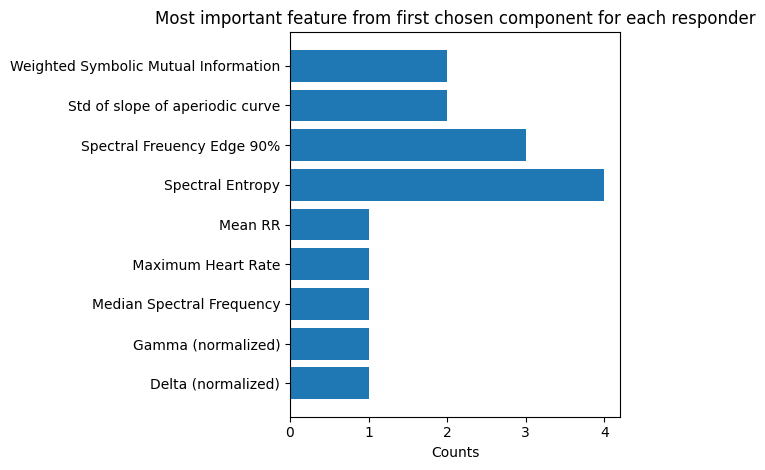

In [122]:
fig, ax = plt.subplots(1)
ax.barh(y=[i for i in range(len(np.unique(features_counter)))], width=np.unique(features_counter, return_counts=True)[1])
ax.set_yticks([i for i in range(len(np.unique(features_counter)))],labels=['Delta (normalized)', 'Gamma (normalized)', 'Median Spectral Frequency', ' Maximum Heart Rate', 'Mean RR', 'Spectral Entropy', 'Spectral Freuency Edge 90%', 'Std of slope of aperiodic curve', 'Weighted Symbolic Mutual Information'])
ax.set_xticks([0,1,2,3,4], labels=[0,1,2,3,4])
ax.set_xlabel('Counts')
ax.set_title('Most important feature from first chosen component for each responder')

"""ax[1].barh(y=[i for i in range(len(np.unique(features_counter2)))], width=np.unique(features_counter2, return_counts=True)[1])
ax[1].set_yticks([i for i in range(len(np.unique(features_counter2)))],labels=['Alpha', 'Gamma',' Maximum Heart Rate', 'Mean Heart Rate', 'Permutation Entropy', 'Std RR', 'Theta', 'Mean of slope of aperiodic curve', 'Std of slope of aperiodic curve', 'Weighted Symbolic Mutual Information'])
ax[1].set_xticks([0,1,2,3], labels=[0,1,2,3])
ax[1].set_xlabel('Counts')
ax[1].set_title('Most important feature from second chosen compomponent')
"""
plt.tight_layout()
plt.show()

# Old code below

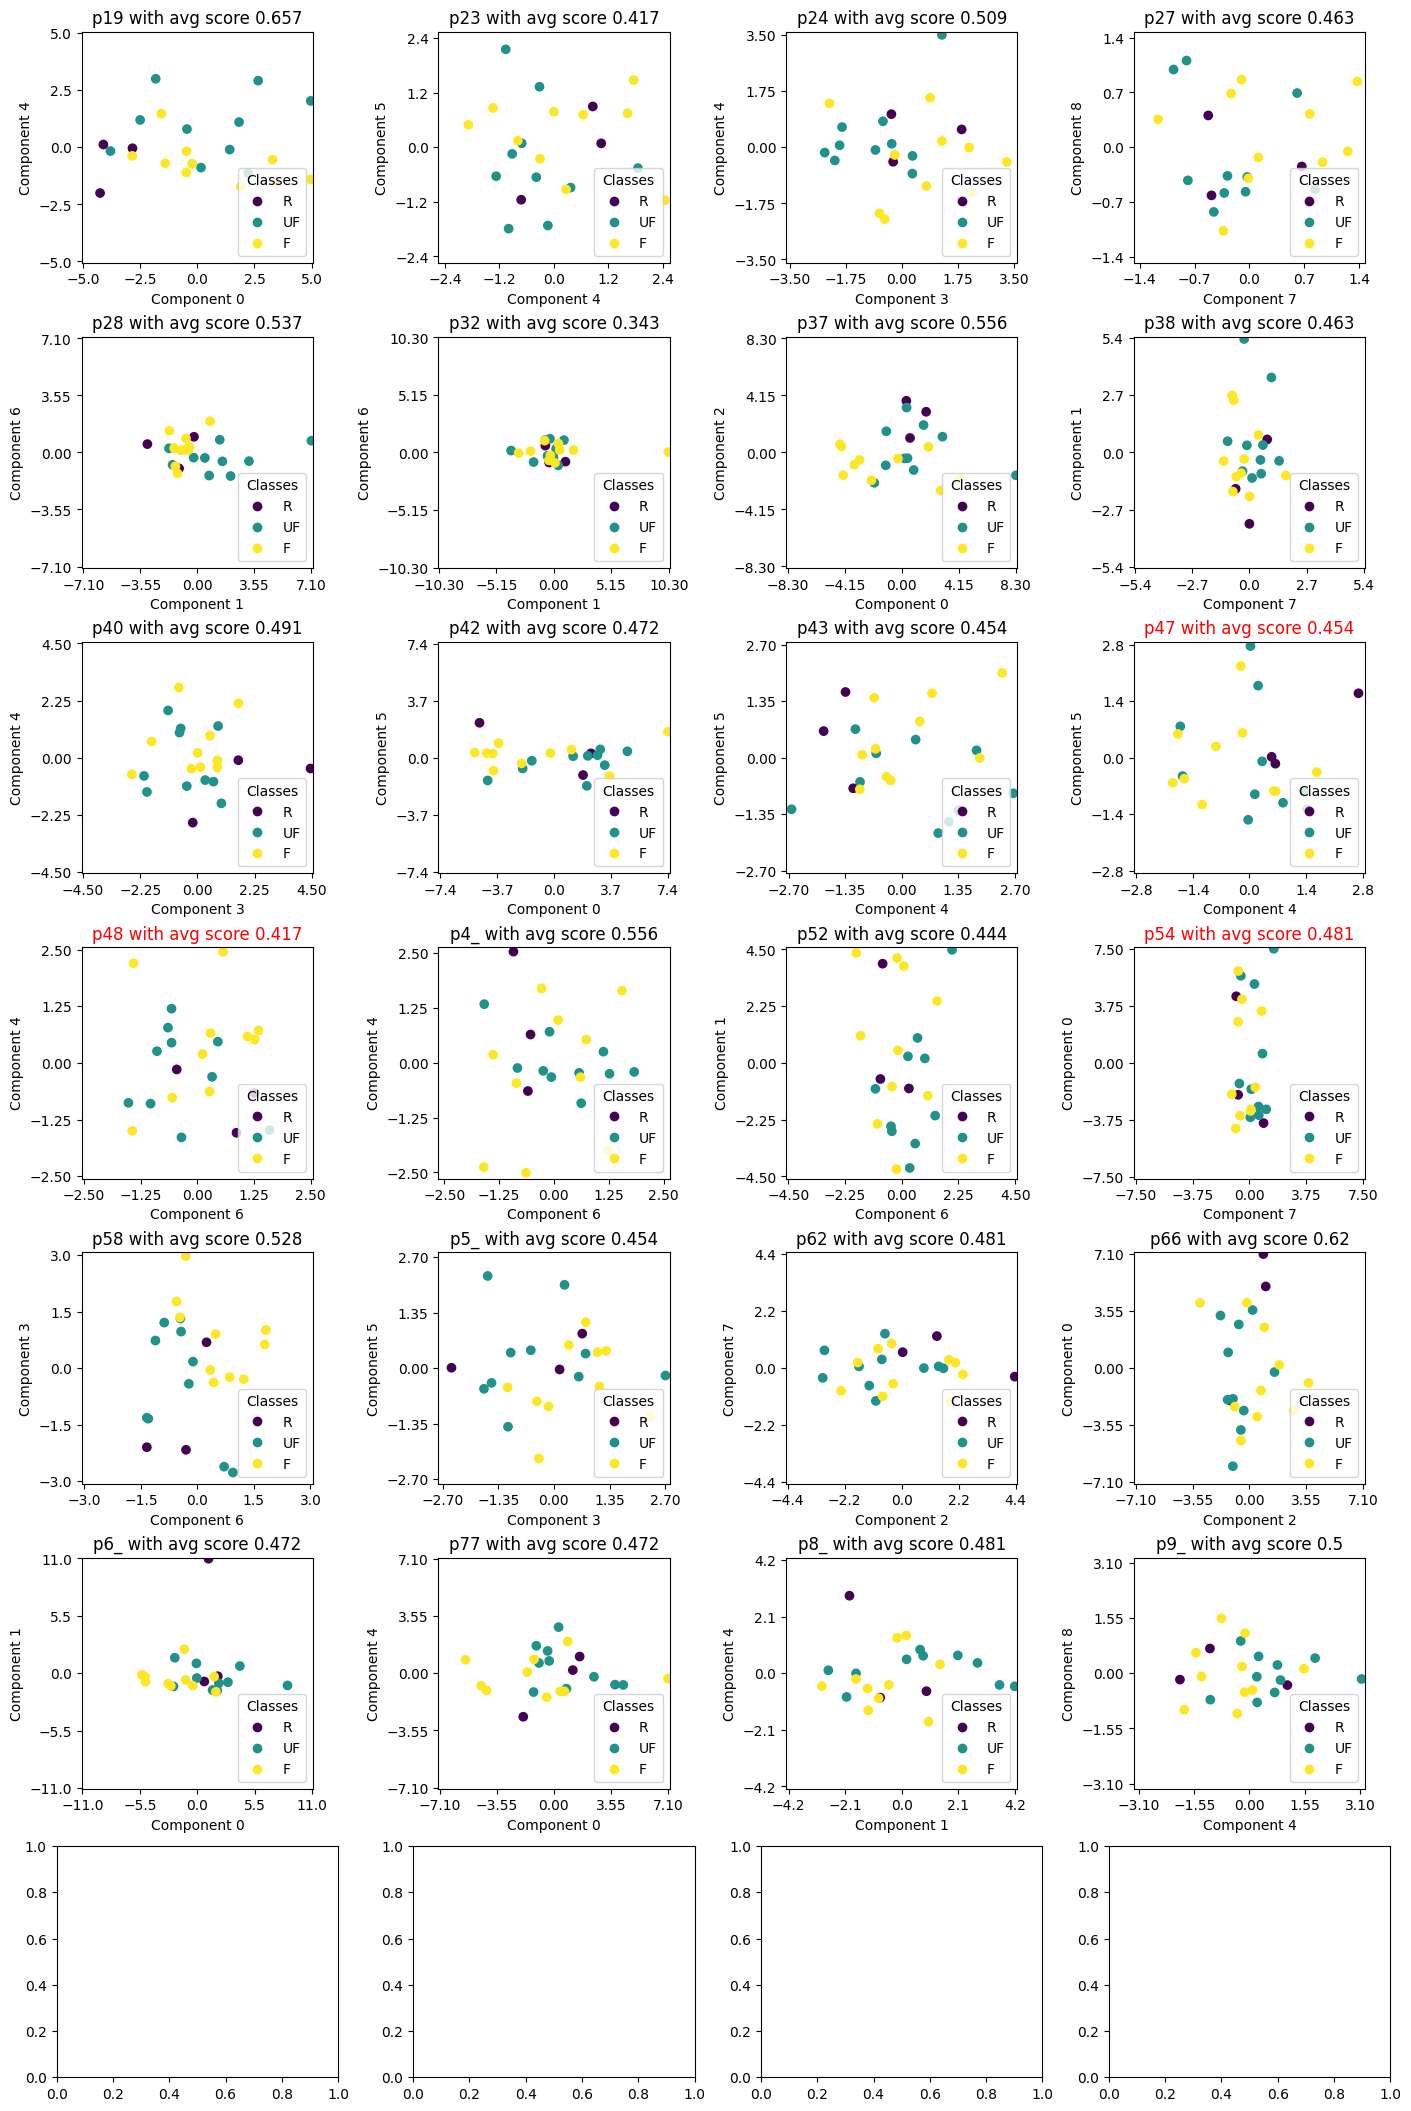

In [12]:
fig, axes = plt.subplots(7,4, figsize=(14,21), constrained_layout=True)

people = list(people_r)

for i,ax in zip(range(len(people)),axes.ravel()):
    y1 = np.array(pd.Series(all_data[i]['Event'],dtype=t).cat.codes)
    n_components = 0.95
    pca = sklearn.decomposition.PCA(n_components=n_components)
    train_X = all_data[i][m_list]
    #print(train_X.shape)
    train_X = sklearn.preprocessing.StandardScaler().fit(train_X).transform(train_X)
    train_X = pca.fit_transform(train_X)
    first_feature = subsets_list[i][1]['feature_idx'][0]
    second_feature = [*subsets_list[i][2]['feature_idx']]
    second_feature.remove(first_feature)
    second_feature = second_feature[0]
    #print(len(y1), len(train_X[first_feature]))
    scatter = ax.scatter(train_X[:,first_feature], train_X[:,second_feature], c=y1)
    max_val = np.max(np.append(abs(train_X[:,first_feature]),abs(train_X[:,second_feature]))) 
    ax.set_ylim(-max_val-0.1,max_val+0.1)
    ax.set_xlim(-max_val-0.1,max_val+0.1)
    ax.set_xticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    ax.set_yticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    xlabel = 'Component ' + str(first_feature)
    ylabel = 'Component ' + str(second_feature)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect('equal', adjustable=None, anchor=None, share=False)
    ax.legend(
        scatter.legend_elements()[0],
        ['R', 'UF', 'F'],
        title="Classes",
        loc = 'lower right'
    )
    if patient_numbers[people[i]] in intersection:
        color = 'r'
    else:
        color = 'k'
    title = str(patient_numbers[people[i]]) + ' with avg score ' + str(round(subsets_list[i][2]['avg_score'],3))
    ax.set_title(title, color=color)

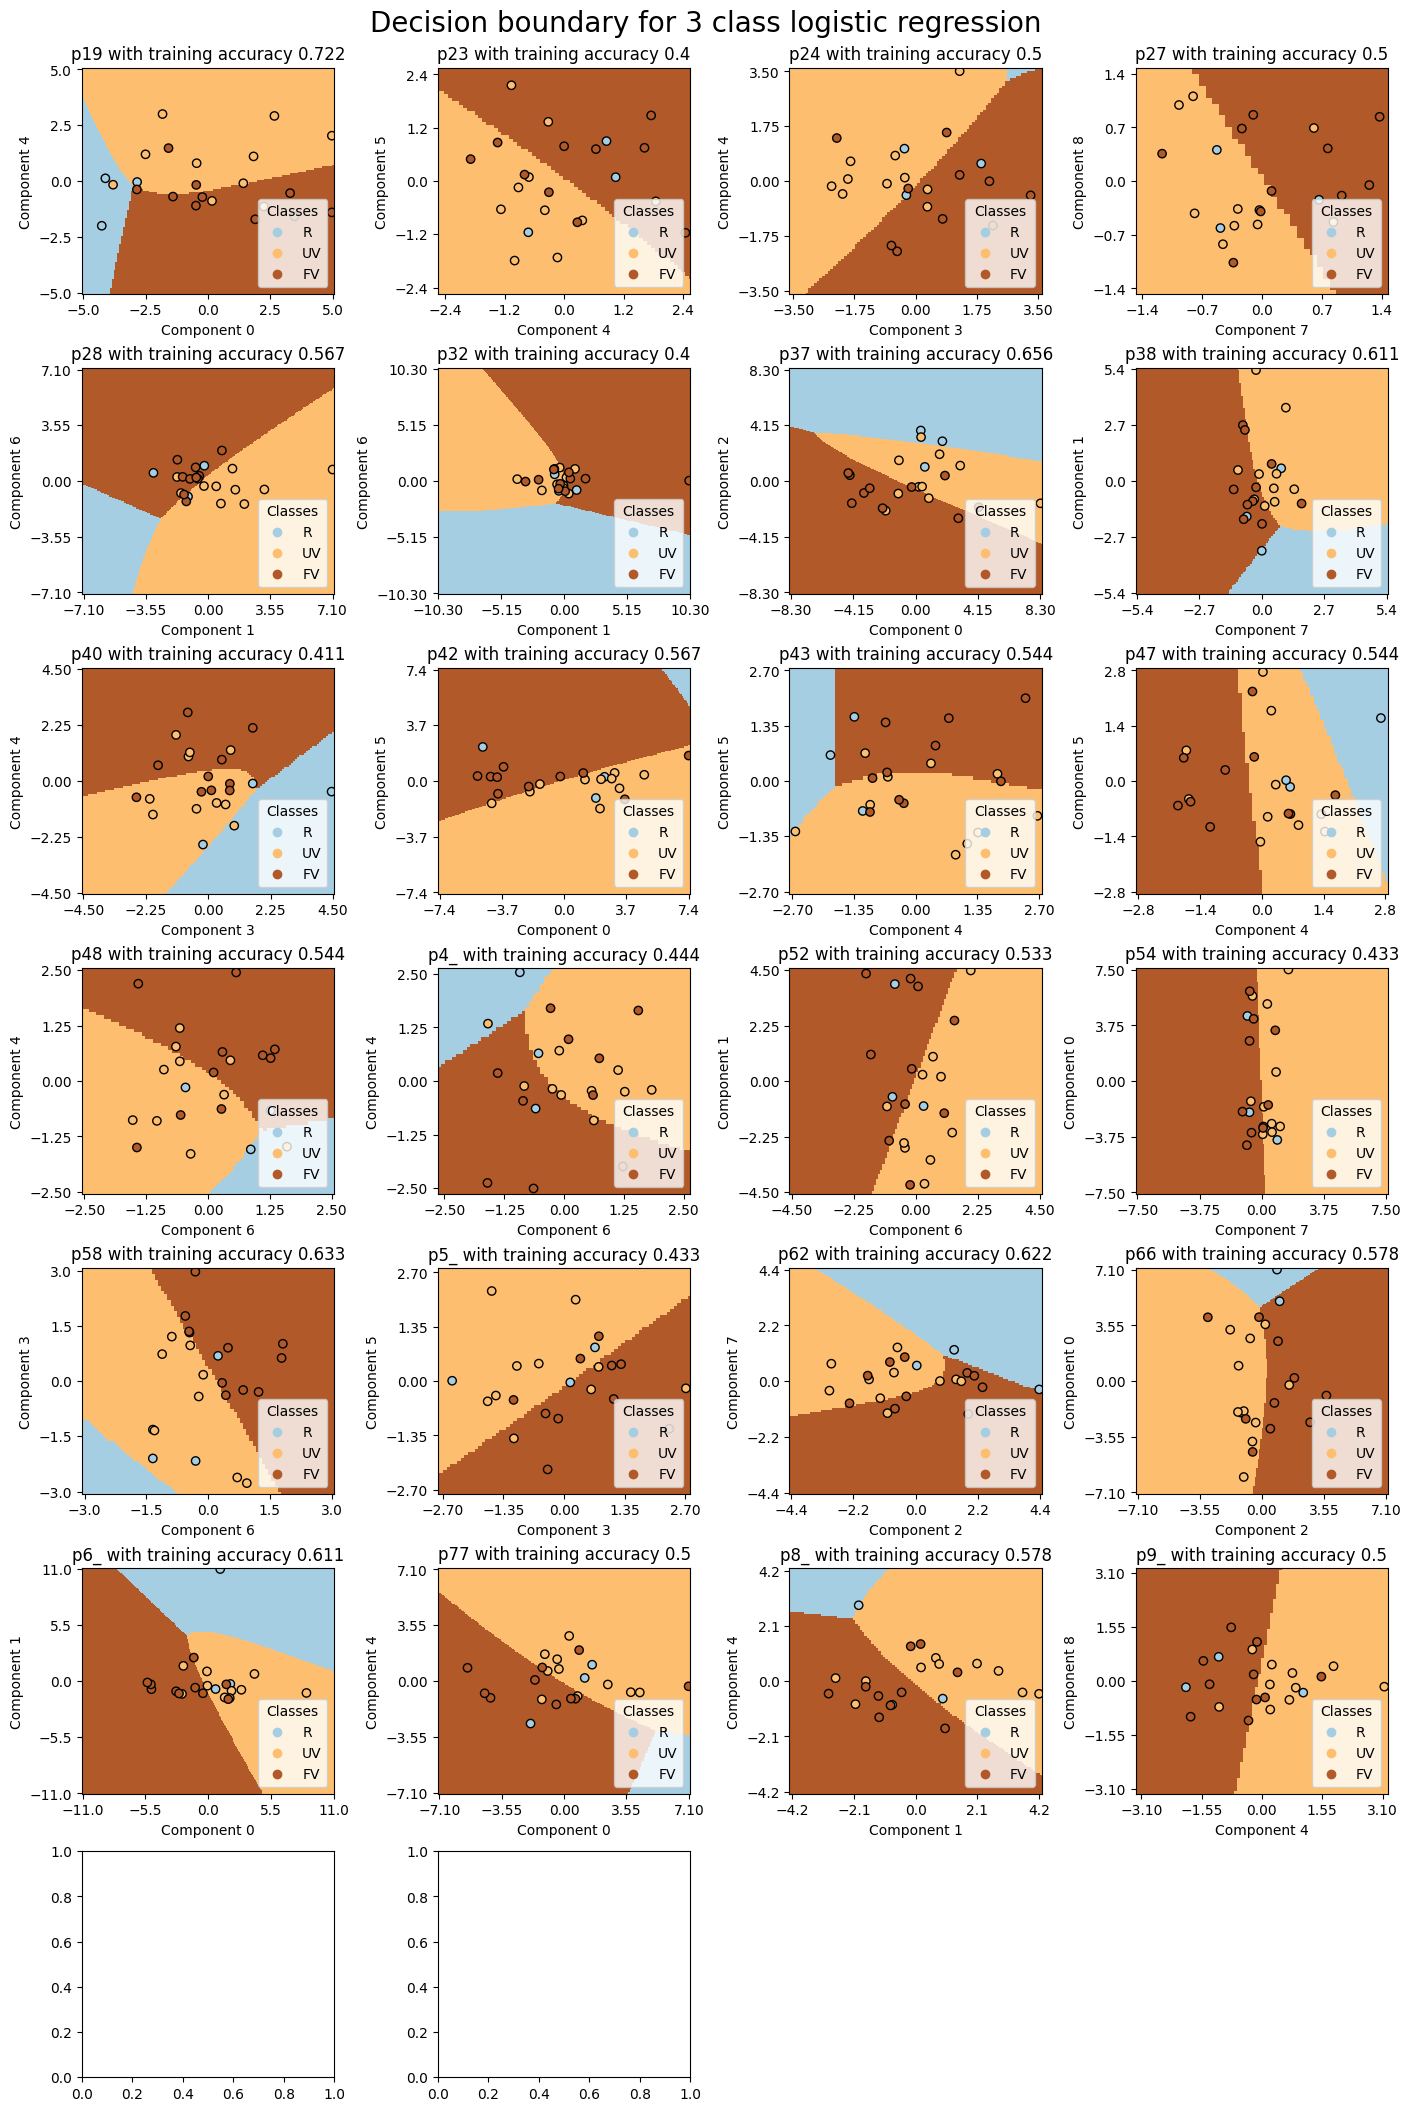

In [25]:
#three-class
#good plots
#cmap = matplotlib.colors.ListedColormap(["gold", "crimson", "indigo"])


people_r = list(people_r)

fig, axes = plt.subplots(7,4, figsize=(14,21), constrained_layout=True)
fig.suptitle('Decision boundary for 3 class logistic regression', fontsize=20)

for i,ax in zip(range(len(people_r)),axes.ravel()):
    y1 = np.array(pd.Series(all_data[i]['Event'],dtype=t).cat.codes)
    #train_y2 = [x if x==1 or x==0 else 1 for x in train_y]
    train_y2 = y1
    n_components = 0.95
    pca = sklearn.decomposition.PCA(n_components=n_components)
    train_X = all_data[i][m_list]
    #print(train_X.shape)
    train_X = sklearn.preprocessing.StandardScaler().fit(train_X).transform(train_X)
    train_X = pca.fit_transform(train_X)
    first_feature = subsets_list[i][1]['feature_idx'][0]
    second_feature = [*subsets_list[i][2]['feature_idx']]
    second_feature.remove(first_feature)
    second_feature = second_feature[0]
    train_X = pd.DataFrame(train_X[:,[first_feature, second_feature]], columns=[first_feature, second_feature])
    ord_clf = OrdinalClassifier(estimator=LogisticRegression(multi_class='multinomial'))
    #ord_clf = LogisticRegression()
    #print(len(y1), len(train_X[first_feature]))
    names = ['R', 'UV', 'FV']
    ord_clf.fit(train_X, train_y2)
    predictions = ord_clf.predict(train_X)
   
    score1 = balanced_accuracy_score(train_y2, predictions)
    #predictions = ord_clf.predict(train_X)
    #predictions = [x if x==1 or x==0 else 1 for x in predictions]
    #two_class_score = [predictions[i]==train_y2[i] for i in range(len(predictions))]
    #two_class_score = np.array(two_class_score).sum()/len(predictions)
    xlabel = 'Component ' + str(first_feature)
    ylabel = 'Component ' + str(second_feature)
    disp = DecisionBoundaryDisplay.from_estimator(ord_clf, train_X,grid_resolution=2000,ax=ax, response_method="predict",plot_method="pcolormesh",shading="auto",xlabel=xlabel,ylabel=ylabel,eps=75, cmap=plt.cm.Paired)
    scatter = disp.ax_.scatter(train_X.iloc[:,0],train_X.iloc[:,1], c=train_y, edgecolors='k', cmap=plt.cm.Paired)
    max_val = np.max(np.append(abs(train_X.iloc[:,0]),abs(train_X.iloc[:,1]))) 
    disp.ax_.set_ylim(-max_val-0.1,max_val+0.1)
    disp.ax_.set_xlim(-max_val-0.1,max_val+0.1)
    disp.ax_.set_xticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    disp.ax_.set_yticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    
    #disp.ax_.set_xlim(-3,3)
    #disp.ax_.set_ylim(-3,3)
    disp.ax_.legend(
        scatter.legend_elements()[0],
        names,
        title="Classes",
        loc = 'lower right'
    )
    if patient_numbers[people_r[i]] in intersection:
        color = 'k' # r if show intersection
    else:
        color = 'k'
    title = str(patient_numbers[people_r[i]]) + ' with training accuracy ' + str(round(score1,3))
    ax.set_title(title, color=color)

fig.delaxes(axes[6][2])
fig.delaxes(axes[6][3])
plt.show()

In [13]:
# Finding non-responders to plot

people_r = list(people_r)
people_nr = []

for i in range(len(all_data)):
    if i not in people_r:
        people_nr.append(i)

In [20]:
# Choosing 8 non-responders (randomly)
import random

chosen_bads = random.choices(people_nr, k=8)
print('Chosen non-responders (index): ', chosen_bads)

Chosen non-responders (index):  [4, 41, 25, 44, 23, 45, 32, 43]


In [21]:
nr_list = [patient_numbers[i] for i in chosen_bads]
print(nr_list)

['p14', 'p53', 'p39', 'p57', 'p36', 'p58', 'p45', 'p56']


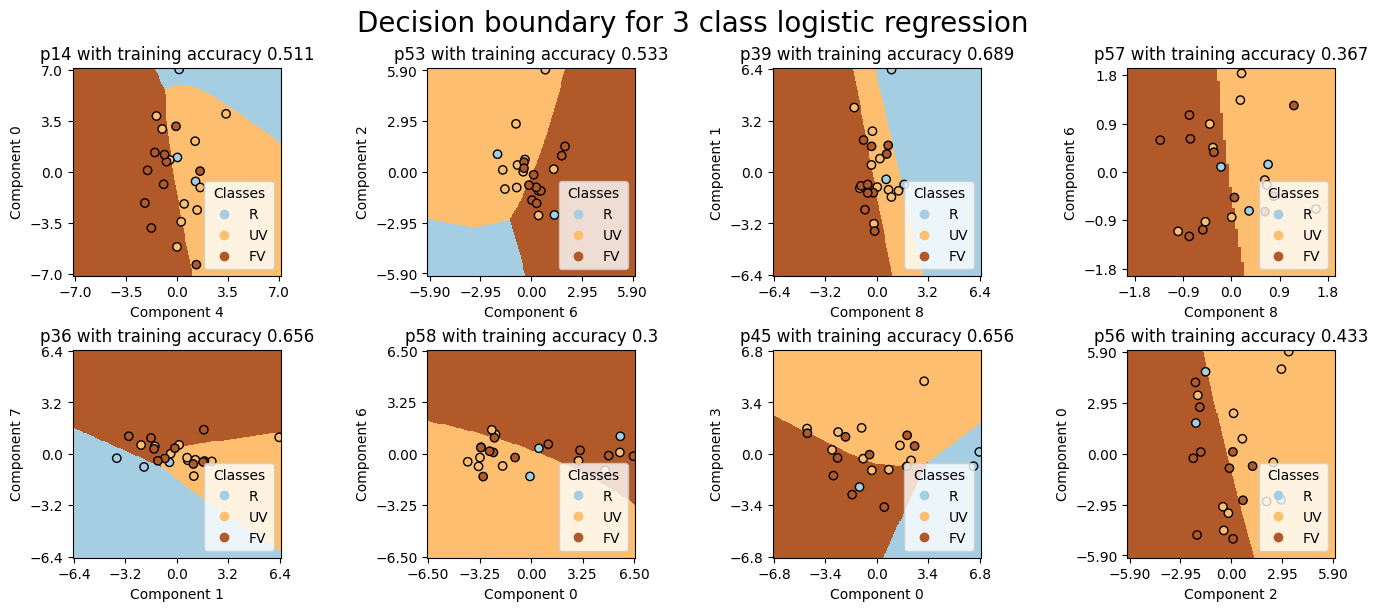

In [22]:
#three-class
#bad plots
#cmap = matplotlib.colors.ListedColormap(["gold", "crimson", "indigo"])

fig, axes = plt.subplots(2,4, figsize=(14,6), constrained_layout=True)
fig.suptitle('Decision boundary for 3 class logistic regression', fontsize=20)

people_r = chosen_bads

for i,ax in zip(range(len(people_r)),axes.ravel()):
    y1 = np.array(pd.Series(all_data[i]['Event'],dtype=t).cat.codes)
    #train_y2 = [x if x==1 or x==0 else 1 for x in train_y]
    train_y2 = y1
    n_components = 0.95
    pca = sklearn.decomposition.PCA(n_components=n_components)
    train_X = all_data[i][m_list]
    #print(train_X.shape)
    train_X = sklearn.preprocessing.StandardScaler().fit(train_X).transform(train_X)
    train_X = pca.fit_transform(train_X)
    first_feature = subsets_list[i][1]['feature_idx'][0]
    second_feature = [*subsets_list[i][2]['feature_idx']]
    second_feature.remove(first_feature)
    second_feature = second_feature[0]
    train_X = pd.DataFrame(train_X[:,[first_feature, second_feature]], columns=[first_feature, second_feature])
    ord_clf = OrdinalClassifier(estimator=LogisticRegression(multi_class='multinomial'))
    names = ['R', 'UV', 'FV']
    ord_clf.fit(train_X, train_y2)
    predictions = ord_clf.predict(train_X)
   
    score1 = balanced_accuracy_score(train_y2, predictions)
    #predictions = ord_clf.predict(train_X)
    #predictions = [x if x==1 or x==0 else 1 for x in predictions]
    #two_class_score = [predictions[i]==train_y2[i] for i in range(len(predictions))]
    #two_class_score = np.array(two_class_score).sum()/len(predictions)
    xlabel = 'Component ' + str(first_feature)
    ylabel = 'Component ' + str(second_feature)
    disp = DecisionBoundaryDisplay.from_estimator(ord_clf, train_X,grid_resolution=600,ax=ax, response_method="predict",plot_method="pcolormesh",shading="auto",xlabel=xlabel,ylabel=ylabel,eps=15, cmap=plt.cm.Paired)
    scatter = disp.ax_.scatter(train_X.iloc[:,0],train_X.iloc[:,1], c=train_y, edgecolors='k', cmap=plt.cm.Paired)
    max_val = np.max(np.append(abs(train_X.iloc[:,0]),abs(train_X.iloc[:,1]))) 
    disp.ax_.set_ylim(-max_val-0.1,max_val+0.1)
    disp.ax_.set_xlim(-max_val-0.1,max_val+0.1)
    disp.ax_.set_xticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    disp.ax_.set_yticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    disp.ax_.set_aspect('equal')
    #disp.ax_.set_xlim(-3,3)
    #disp.ax_.set_ylim(-3,3)
    disp.ax_.legend(
        scatter.legend_elements()[0],
        names,
        title="Classes",
        loc = 'lower right'
    )

    title = str(patient_numbers[people_r[i]]) + ' with training accuracy ' + str(round(score1,3))
    ax.set_title(title, color=color)

plt.show()

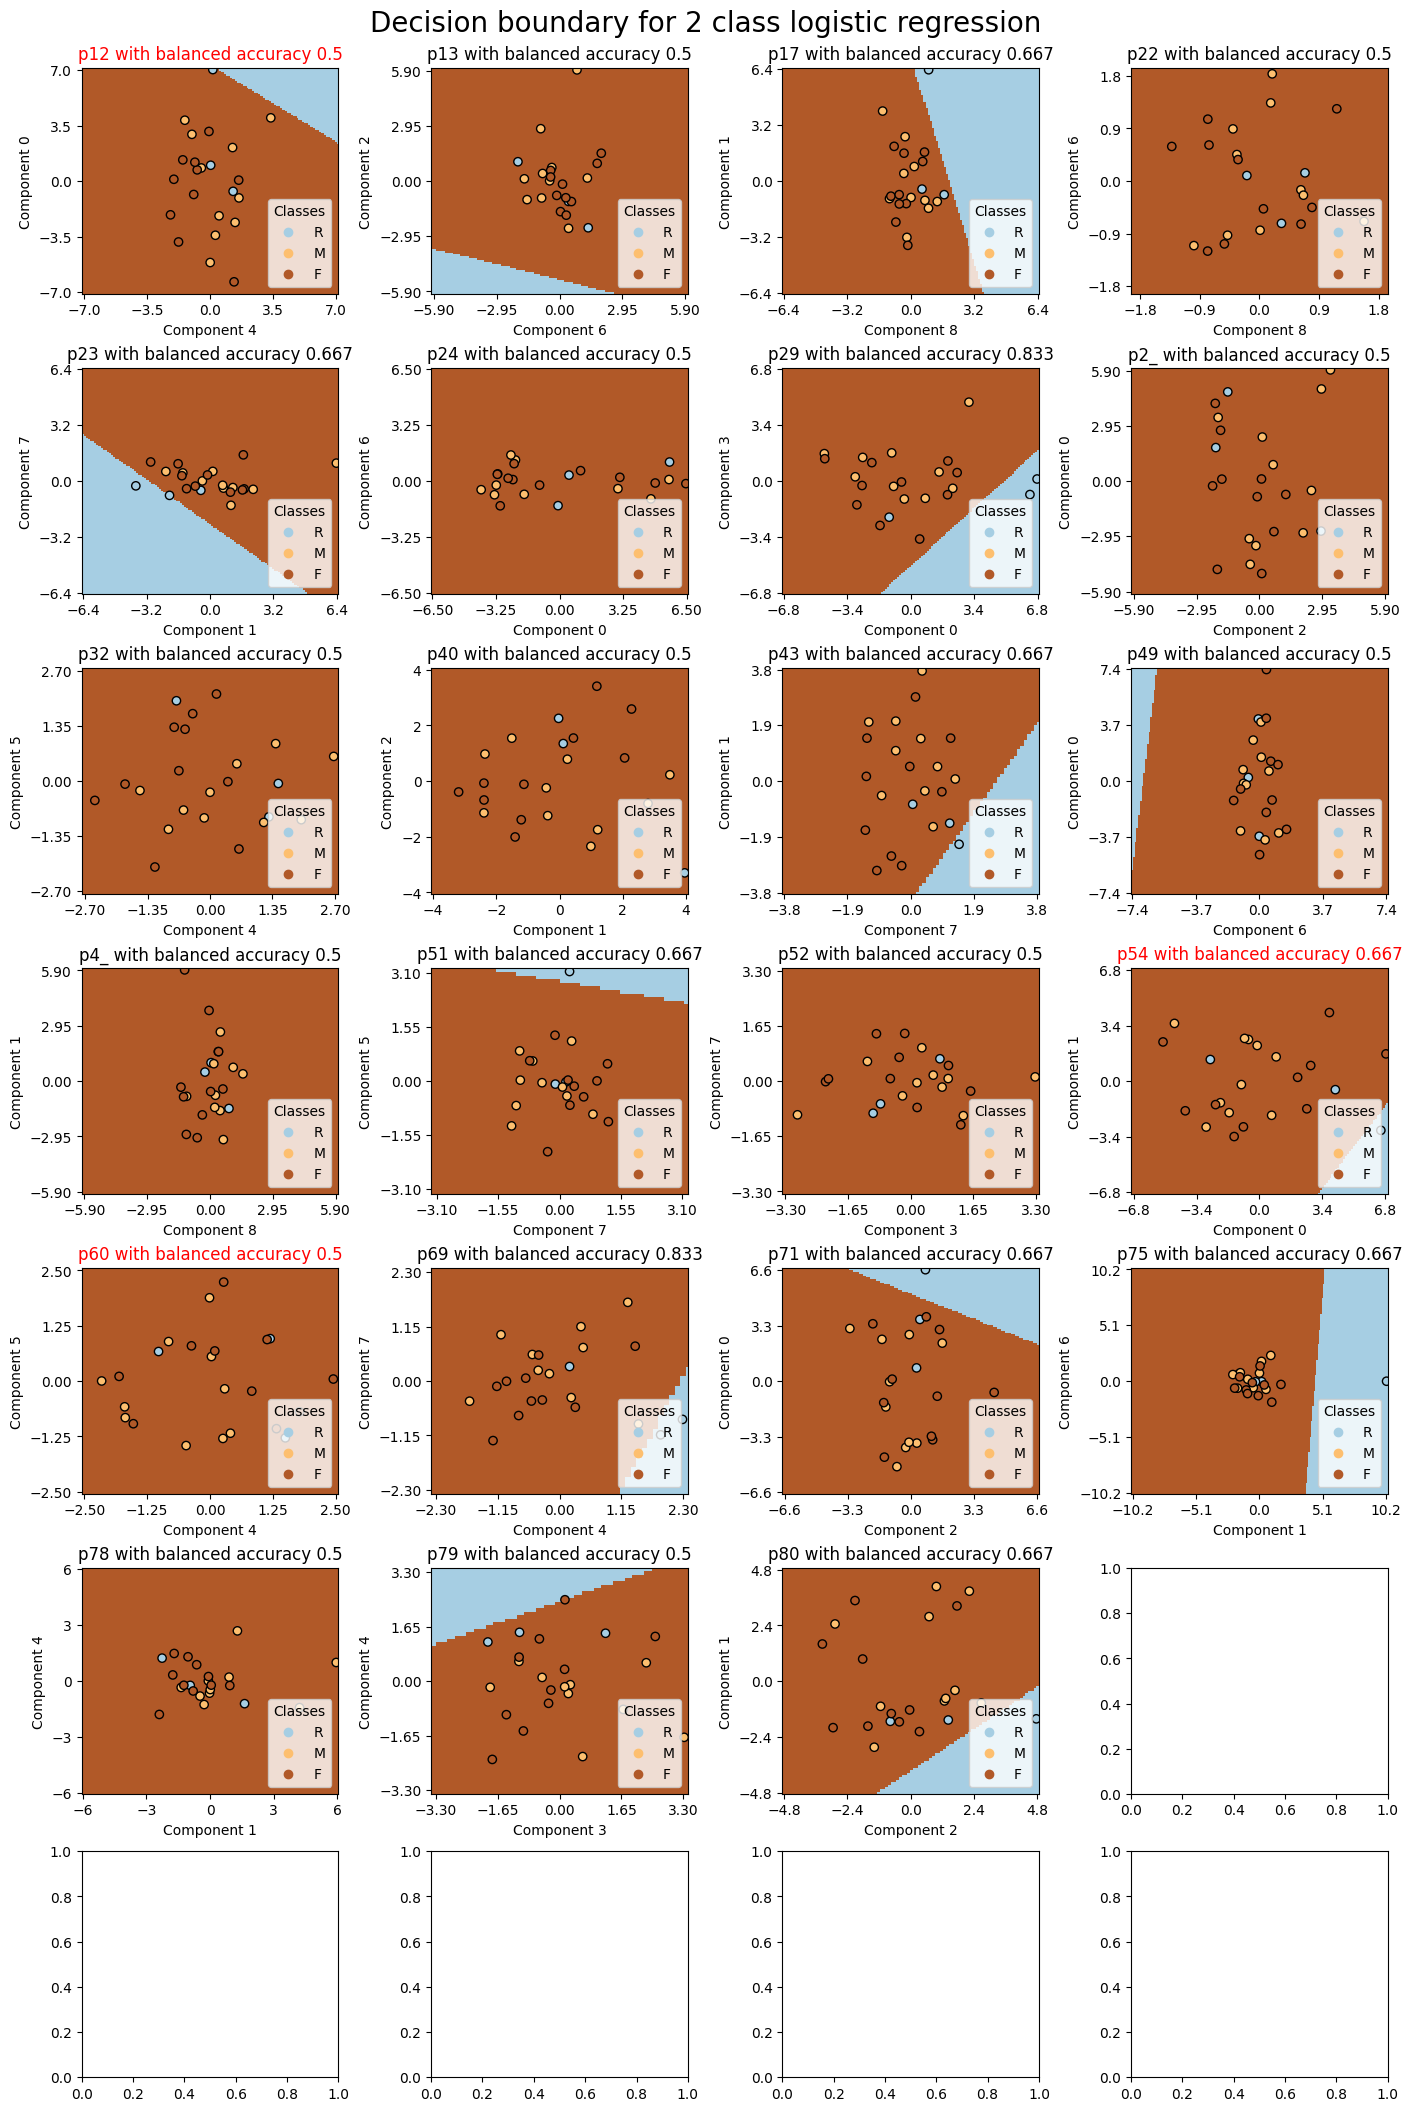

In [23]:
#two-class
#good plots
import matplotlib.colors
#cmap = matplotlib.colors.ListedColormap(["gold", "crimson", "indigo"])

fig, axes = plt.subplots(7,4, figsize=(14,21), constrained_layout=True)
fig.suptitle('Decision boundary for 2 class logistic regression', fontsize=20)

for i,ax in zip(range(len(people)),axes.ravel()):
    y1 = np.array(pd.Series(all_data[i]['Event'],dtype=t).cat.codes)
    train_y2 = [x if x==1 or x==0 else 1 for x in train_y]
    #train_y2 = y1
    n_components = 0.95
    pca = sklearn.decomposition.PCA(n_components=n_components)
    train_X = all_data[i][m_list]
    #print(train_X.shape)
    train_X = sklearn.preprocessing.StandardScaler().fit(train_X).transform(train_X)
    train_X = pca.fit_transform(train_X)
    first_feature = subsets_list[i][1]['feature_idx'][0]
    second_feature = [*subsets_list[i][2]['feature_idx']]
    second_feature.remove(first_feature)
    second_feature = second_feature[0]
    train_X = pd.DataFrame(train_X[:,[first_feature, second_feature]], columns=[first_feature, second_feature])
    #ord_clf = OrdinalClassifier(estimator=LogisticRegression(multi_class='multinomial'))
    ord_clf = LogisticRegression()
    #print(len(y1), len(train_X[first_feature]))
    names = ['R', 'M', 'F']
    ord_clf.fit(train_X, train_y2)
    predictions = ord_clf.predict(train_X)
    score1 = balanced_accuracy_score(train_y2, predictions)    
    #predictions = ord_clf.predict(train_X)
    #predictions = [x if x==1 or x==0 else 1 for x in predictions]
    #two_class_score = [predictions[i]==train_y2[i] for i in range(len(predictions))]
    #two_class_score = np.array(two_class_score).sum()/len(predictions)
    xlabel = 'Component ' + str(first_feature)
    ylabel = 'Component ' + str(second_feature)
    disp = DecisionBoundaryDisplay.from_estimator(ord_clf, train_X,grid_resolution=2000,ax=ax, response_method="predict",plot_method="pcolormesh",shading="auto",xlabel=xlabel,ylabel=ylabel,eps=100, cmap=plt.cm.Paired)
    scatter = disp.ax_.scatter(train_X.iloc[:,0],train_X.iloc[:,1], c=train_y, edgecolors='k', cmap=plt.cm.Paired)
    max_val = np.max(np.append(abs(train_X.iloc[:,0]),abs(train_X.iloc[:,1]))) 
    disp.ax_.set_ylim(-max_val-0.1,max_val+0.1)
    disp.ax_.set_xlim(-max_val-0.1,max_val+0.1)
    disp.ax_.set_xticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    disp.ax_.set_yticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    disp.ax_.legend(
        scatter.legend_elements()[0],
        names,
        title="Classes",
        loc = 'lower right'
    )
    if patient_numbers[people[i]] in intersection:
        color = 'r'
    else:
        color = 'k'
    title = str(patient_numbers[people[i]]) + ' with balanced accuracy ' + str(round(score1,3))
    ax.set_title(title, color=color)
plt.show()